In [16]:
from matplotlib import pyplot as plt
from keras.models import load_model
import scipy.io
import numpy as np
import tensorflow as tf
from keras import backend as K
import keras

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

In [15]:
def yc_patch(A,l1,l2,o1,o2):

    n1,n2=np.shape(A);
    tmp=np.mod(n1-l1,o1)
    if tmp!=0:
        print(np.shape(A), o1-tmp, n2)
        A=np.concatenate([A,np.zeros((o1-tmp,n2))],axis=0)

    tmp=np.mod(n2-l2,o2);
    if tmp!=0:
        A=np.concatenate([A,np.zeros((A.shape[0],o2-tmp))],axis=-1);


    N1,N2 = np.shape(A)
    X=[]
    for i1 in range (0,N1-l1+1, o1):
        for i2 in range (0,N2-l2+1,o2):
            tmp=np.reshape(A[i1:i1+l1,i2:i2+l2],(l1*l2,1));
            X.append(tmp);
    X = np.array(X)
    return X[:,:,0]


def yc_patch_inv(X1, n1, n2, l1, l2, o1, o2):
    tmp1 = np.mod(n1 - l1, o1)
    tmp2 = np.mod(n2 - l2, o2)
    if (tmp1 != 0) and (tmp2 != 0):
        A = np.zeros((n1 + o1 - tmp1, n2 + o2 - tmp2))
        mask = np.zeros((n1 + o1 - tmp1, n2 + o2 - tmp2))

    if (tmp1 != 0) and (tmp2 == 0):
        A = np.zeros((n1 + o1 - tmp1, n2))
        mask = np.zeros((n1 + o1 - tmp1, n2))

    if (tmp1 == 0) and (tmp2 != 0):
        A = np.zeros((n1, n2 + o2 - tmp2))
        mask = np.zeros((n1, n2 + o2 - tmp2))

    if (tmp1 == 0) and (tmp2 == 0):
        A = np.zeros((n1, n2))
        mask = np.zeros((n1, n2))

    N1, N2 = np.shape(A)
    ids = 0
    for i1 in range(0, N1 - l1 + 1, o1):
        for i2 in range(0, N2 - l2 + 1, o2):
            # print(i1,i2)
            #       [i1,i2,ids]
            A[i1:i1 + l1, i2:i2 + l2] = A[i1:i1 + l1, i2:i2 + l2] + np.reshape(X1[:, ids], (l1, l2))
            mask[i1:i1 + l1, i2:i2 + l2] = mask[i1:i1 + l1, i2:i2 + l2] + np.ones((l1, l2))
            ids = ids + 1

    A = A / mask;
    A = A[0:n1, 0:n2]

    return A

In [72]:
### load trained model ###
model = load_model('best_model_field_fcdnet.h5')

### load test data ###
mat = scipy.io.loadmat ("./Test/Noisy_72.mat")
dn = mat['dn']

In [75]:
w1=48
w2=48
z1=24
z2=24

n1,n2 = np.shape(dn)
test = yc_patch(dn, w1, w2, z1, z2)
test = np.array(test)
d = np.reshape(test,(test.shape[0], w1, w2,1))

### output the denoised data

predicted = model.predict(d)

predicted = np.reshape(predicted,(predicted.shape[0],w1*w2))
predicted = np.transpose(predicted)
predicted = yc_patch_inv(predicted,n1,n2,w1,w2,z1,z2)
scipy.io.savemat("./Test/de_72_FCDNet.mat", mdict={'predicted': predicted})

(2000, 960) 16 960


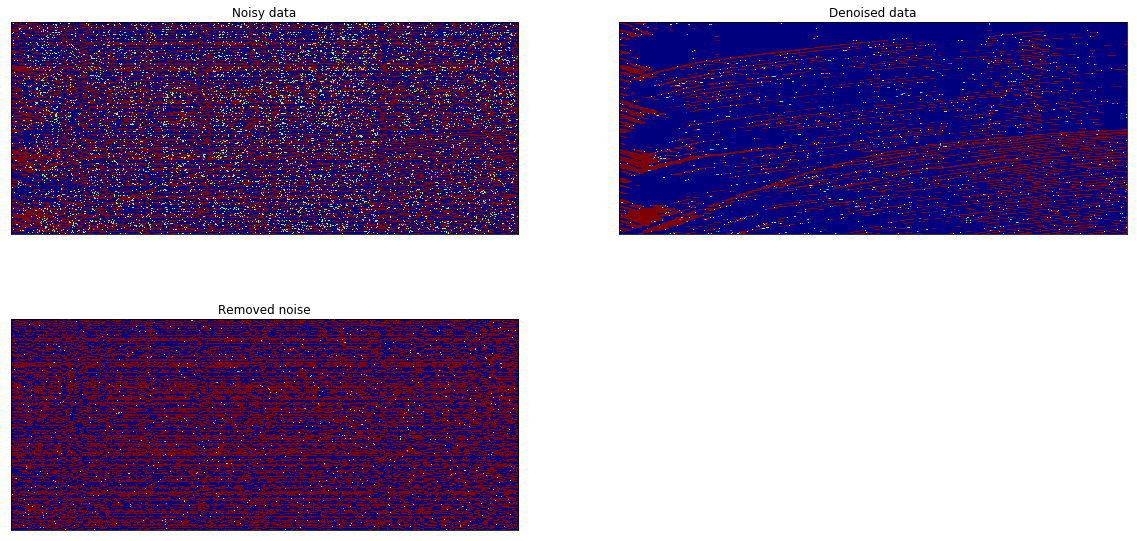

In [76]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(2,2,1)
plt.imshow(dn,cmap='jet',clim=(-0.2, 0.2),aspect=0.2);ax.set_xticks([]);ax.set_yticks([]);
plt.title('Noisy data');
ax = fig.add_subplot(2,2,2)
plt.imshow(predicted,cmap='jet',clim=(-0.2, 0.2),aspect=0.2);ax.set_xticks([]);ax.set_yticks([]);
plt.title('Denoised data');
ax = fig.add_subplot(2,2,3)
plt.imshow(dn-predicted,cmap='jet',clim=(-0.2, 0.2),aspect=0.2);ax.set_xticks([]);ax.set_yticks([]);
plt.title('Removed noise');
plt.show()